# Requirements

In [11]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import nltk

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geoplot as gplt

import gspread
from google.oauth2 import service_account # based on google-auth library

import sddk

In [12]:
# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".png", fig)

In [13]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [14]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import datasets

In [15]:
LIRE = gpd.read_parquet("../data/large_data/LIREg_occupsorgs.parquet")
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry,is_western,large_city_ID,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,"['Augusti/Augustae', 'ordo equester', 'tria no...",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313,Augusti/Augustae; litterae erasae; ordo equest...,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,HD052964,None,Fortissimo et Piissimo Caesari domino nostro G...,Cowey,honorific inscription,3-5.3 cm,"AE 1993, 1406.; V. Papadopoulou, AD 43 B, 1988...",checked with photo,99 cm,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,"[{'name': 'Gal. Val. [[Maximiano]]', 'nomen': ...",67 cm,None,statue base,Epirus,67 cm,Fortissimo et piis/simo Caesari d(omino) n(ost...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Photike,2014-09-16,Ípeiros,Paramythía,https://edh-www.adw.uni-heidelberg.de/edh/geog...,None,https://www.trismegistos.org/text/121715,{ },{ },121715,"['http://www.trismegistos.org/place/000655', '...",Fortissimo et piissimo Caesari...,309 AD – 313 AD,21,unbestimmt,57.0,Statuenbasis,138,unbestimmt,1000.0,69,Ehreninschrift,honorific inscription,Certain,99.0,67.0,67.0,NULL,statue base,Certain,Epirus,Certain,Greece,Certain,Photike,Certain,Ípeiros,Certain,Paramythía,Certain,Agios Athanasios,Certain,309 AD – 313 AD,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Agios Athanasios,None,Fragma Kalama,None,data available,None,None,313.0,Latin,309.0,"[20.7668, 39.4512]",Fortissimo et piissimo Caesari domino nostro G...,rest,False,Dodona,31,1000.0,"[20.787767, 39.546432]",minor,0.097513,honorific inscription,1.0,POINT (20.76680 39.45120),False,65,"[20.733395, 39.026505]",47237.78,7,"[20.987, 39.158]",37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tege

In [19]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_merged = gpd.GeoSeries(pleiades_regions.unary_union)

# Spatial distribution of inscriptions by context

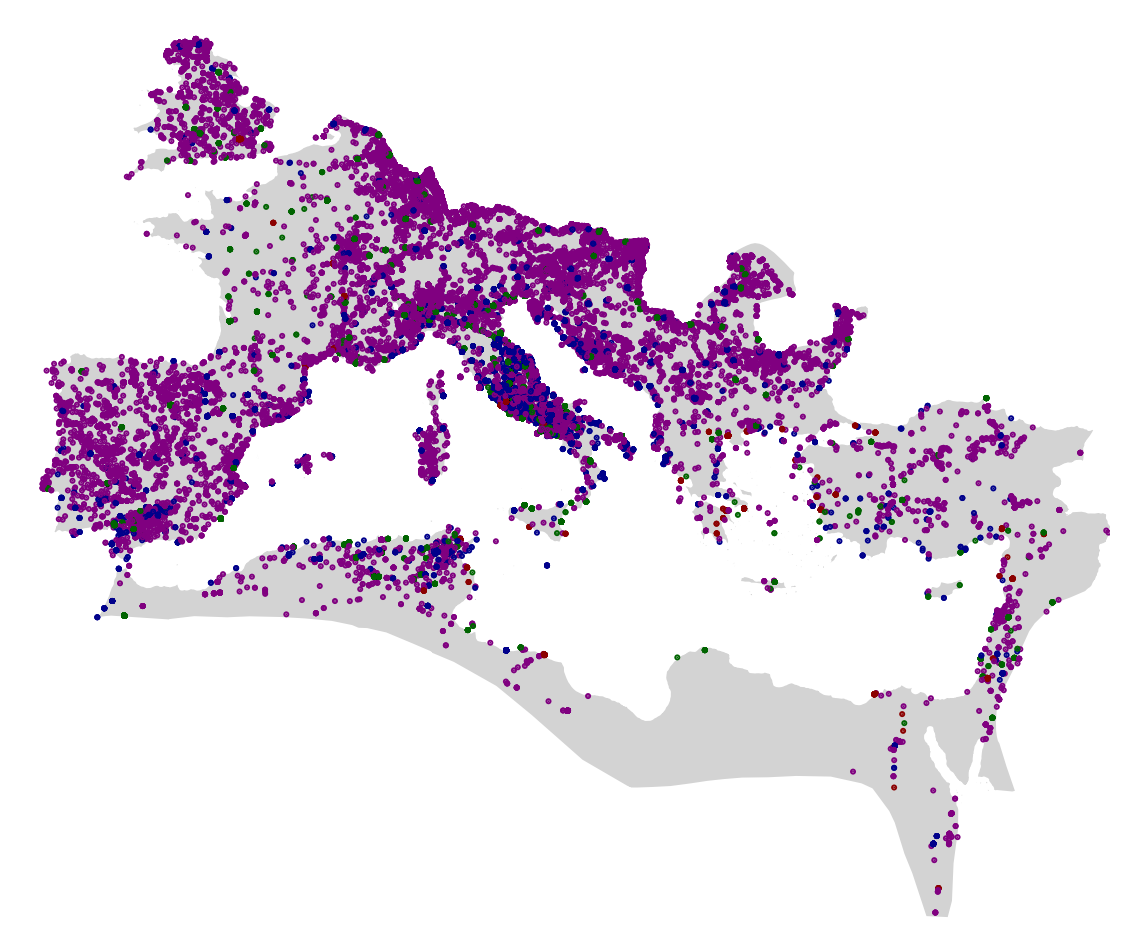

In [20]:
context_color_dict = {"large" : "darkred",
                      "medium" : "darkgreen",
                      "small" : "darkblue",
                      "rural" : "purple"}
colors = LIRE["urban_context_alt"].apply(lambda x: context_color_dict[x])

fig, ax = plt.subplots(figsize=(5.2,3.2), tight_layout=True)
pleiades_regions_merged.plot(ax=ax, color="lightgray")
LIRE.plot(ax=ax, markersize=0.2, color=colors)
ax.set_axis_off()
ax.set_xlim(-10, 41)
ax.set_ylim(23, 55.5)
plt.show()

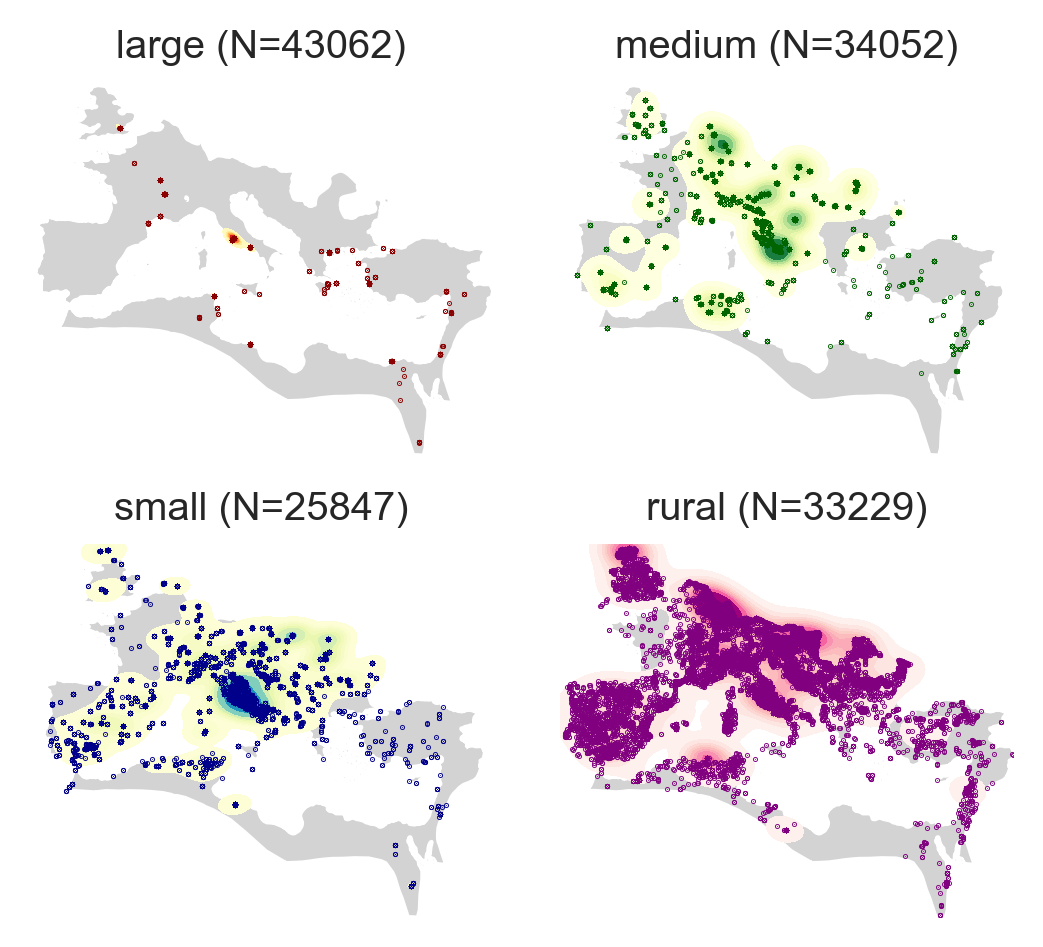

In [21]:
#color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
#colors: https://matplotlib.org/stable/gallery/color/named_colors.html
fig, axs = plt.subplots(2,2, figsize=(5.2,3.2), tight_layout=True)

for ax, context, color, cmap in zip(
        axs.ravel(),
        ["large", "medium", "small", "rural"],
        ["darkred", "darkgreen", "darkblue","purple"],
        ["YlOrRd", "YlGn", "YlGnBu", "RdPu"]):
    pleiades_regions_merged.plot(ax=ax, color="lightgray")
    df = LIRE[LIRE["urban_context_alt"]==context]
    gplt.kdeplot(df, cmap=plt.get_cmap(cmap), ax=ax, shade=True, zorder=2)
    df.plot(ax=ax, marker=".", markersize=0.2, color=color, zorder=3)
    ax.set_axis_off()
    ax.set_xlim(-10, 41)
    ax.set_ylim(23, 55.5)
    ax.set_title(context + " (N={0})".format(str(len(df))))


In [9]:
save_figure(fig, "lire_spatial_by_context")

A file with the same name ("lire_spatial_by_context.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/lire_spatial_by_context.eps"
A file with the same name ("lire_spatial_by_context.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/lire_spatial_by_context.png"


# Occupations and organizations by context

In [8]:
# OCCUPATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[LIRE["urban_context_alt"]==context]["occups_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.04718777576517579
medium 0.037413367790438155
small 0.04600147018996402
rural 0.021878479641277197


In [33]:
# OCCUPATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    if context == "large":
        print(context, LIRE[(LIRE["urban_context_alt"]==context) & (LIRE["nearest_city"]=="Roma")]["occups_N"].sum() / len(LIRE[(LIRE["urban_context_alt"]==context) & (LIRE["nearest_city"]=="Roma")]))
    else:
        print(context, LIRE[(LIRE["urban_context_alt"]==context) & (LIRE["is_western"])]["occups_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.04419435985701046
medium 0.034652883824738634
small 0.041513521878748016
rural 0.0182370820668693


In [31]:
# OCCUPATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    if context == "large":
        print(context, LIRE[(LIRE["urban_context_alt"]==context) & ~(LIRE["nearest_city"]=="Roma")]["occups_N"].sum() / len(LIRE[(LIRE["urban_context_alt"]==context) & ~(LIRE["nearest_city"]=="Roma")]))
    else:
        print(context, LIRE[(LIRE["urban_context_alt"]==context) & (LIRE["is_western"])]["occups_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.06852935623938078
medium 0.034652883824738634
small 0.041513521878748016
rural 0.0182370820668693


In [9]:
# OCCUPATIONS frequency accross location categories - WESTERN
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[(LIRE["urban_context_alt"]==context) & (LIRE["is_western"])]["occups_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.04679299614509312
medium 0.034652883824738634
small 0.041513521878748016
rural 0.0182370820668693


# Closer look at urban contexts...

# Bootstrap test

based on Brezina 2018, p. 232, drawing on Lijffijt 2016

In [34]:
def get_bootstrap(df, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        sample_df = df.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values

def get_statistics(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(((len(df1_values) - 1) * ((np.std(df1_values)**2))) + ((len(df2_values) - 1) * (np.std(df2_values)**2)) / (len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]

def bootstrap_test(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df1, df2, 1000, 1000, column, row_function)
    p1 =  sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

### Occupations - urban contexts

In [35]:
# LIRE - occupations all-URBAN vs RURAL areas
p, cohens_d, CI95, lire_occups_urban_rural = bootstrap_test(LIRE[~(LIRE["urban_context_alt"]=="rural")], LIRE[LIRE["urban_context_alt"]=="rural"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.03396603396603388, 0.0796312190475608, (2.0, 45.0))

In [36]:
# LIRE - occupations LARGE vs MEDIUM city areas
p, cohens_d, CI95, lire_occups_large_medium = bootstrap_test(LIRE[LIRE["urban_context_alt"]=="large"], LIRE[LIRE["urban_context_alt"]=="medium"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.4235764235764236, 0.03140579440197482, (-16.0, 35.0))

In [37]:
# LIRE - occupations SMALL vs RURAL areas
p, cohens_d, CI95, lire_occups_small_rural = bootstrap_test(LIRE[LIRE["urban_context_alt"]=="small"], LIRE[LIRE["urban_context_alt"]=="rural"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.013986013986013887, 0.09092074605256571, (4.0, 44.0))

In [50]:
# LIRE - occupations SMALL vs RURAL areas
p, cohens_d, CI95, lire_occups_rome_large = bootstrap_test(LIRE[(LIRE["urban_context_alt"]=="large") & (LIRE["nearest_city"]=="Roma")], LIRE[(LIRE["urban_context_alt"]=="large") & ~(LIRE["nearest_city"]=="Roma")], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.11488511488511488, -0.08852734399272734, (-60.0, 5.0))

## Box plot

In [38]:
labels=[
    "large city",
    "medium city",
    "small city",
    "rural area"
]

In [39]:
labels * 2

['large city',
 'medium city',
 'small city',
 'rural area',
 'large city',
 'medium city',
 'small city',
 'rural area']

In [40]:
len(lire_occups_large_medium + lire_occups_small_rural)

4

In [41]:
stat_series = []
for label, data in zip(labels, lire_occups_large_medium + lire_occups_small_rural):
    stat_series.append(pd.Series(data).describe())

In [42]:
contexts = labels
measurements = ["occups. per 1,000 ins."] * 4

occups_contexts_descriptive = pd.DataFrame([measurements, contexts], index=["measurement","context"]).T.join(pd.DataFrame(stat_series))

for col in ["count",  "min", "25%", "50%", "75%", "max"]:
    occups_contexts_descriptive[col] = occups_contexts_descriptive[col].astype(int)
occups_contexts_descriptive.drop("count", inplace=True, axis=1)
occups_contexts_descriptive.rename(columns={"count" : "N of bootstraps"}, inplace=True)
occups_contexts_descriptive = occups_contexts_descriptive.round(2)
occups_contexts_descriptive

,measurement,context,mean,std,min,25%,50%,75%,max
0,"occups. per 1,000 ins.",large city,47.16,9.88,25,41,46,53,88
1,"occups. per 1,000 ins.",medium city,37.36,8.25,16,32,37,42,76
2,"occups. per 1,000 ins.",small city,45.58,8.28,25,40,45,51,80
3,"occups. per 1,000 ins.",rural area,21.78,5.55,7,18,21,25,43


In [43]:
print(occups_contexts_descriptive.to_latex(index=False, bold_rows=True, multirow=True))

\begin{tabular}{llrrrrrrr}
\toprule
           measurement &     context &  mean &  std &  min &  25\% &  50\% &  75\% &  max \\
\midrule
occups. per 1,000 ins. &  large city & 47.16 & 9.88 &   25 &   41 &   46 &   53 &   88 \\
occups. per 1,000 ins. & medium city & 37.36 & 8.25 &   16 &   32 &   37 &   42 &   76 \\
occups. per 1,000 ins. &  small city & 45.58 & 8.28 &   25 &   40 &   45 &   51 &   80 \\
occups. per 1,000 ins. &  rural area & 21.78 & 5.55 &    7 &   18 &   21 &   25 &   43 \\
\bottomrule
\end{tabular}



In [44]:
occups_contexts_descriptive.to_csv("../data/occups_contexts_descriptive.csv")

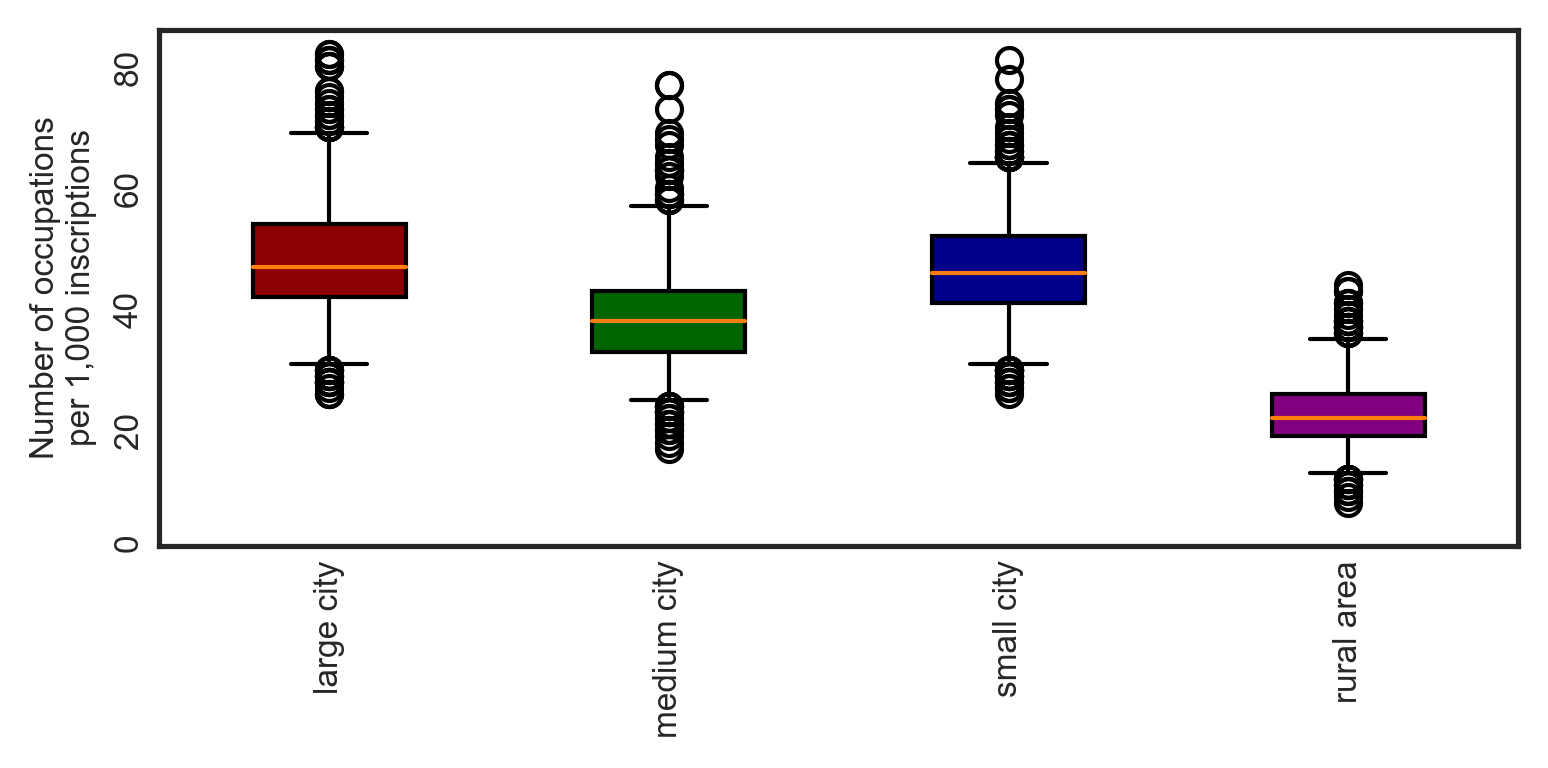

In [45]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax1 = plt.subplots(figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot(lire_occups_large_medium + lire_occups_small_rural, whis=[2.5, 97.5], labels=labels,
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 85)

# fill with colors
colors = ["darkred", "darkgreen", "darkblue", "purple"]
#for bplot in bplot1:
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

In [46]:
save_figure(fig, "occups_by_context_box")

A file with the same name ("occups_by_context_box.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_by_context_box.png"


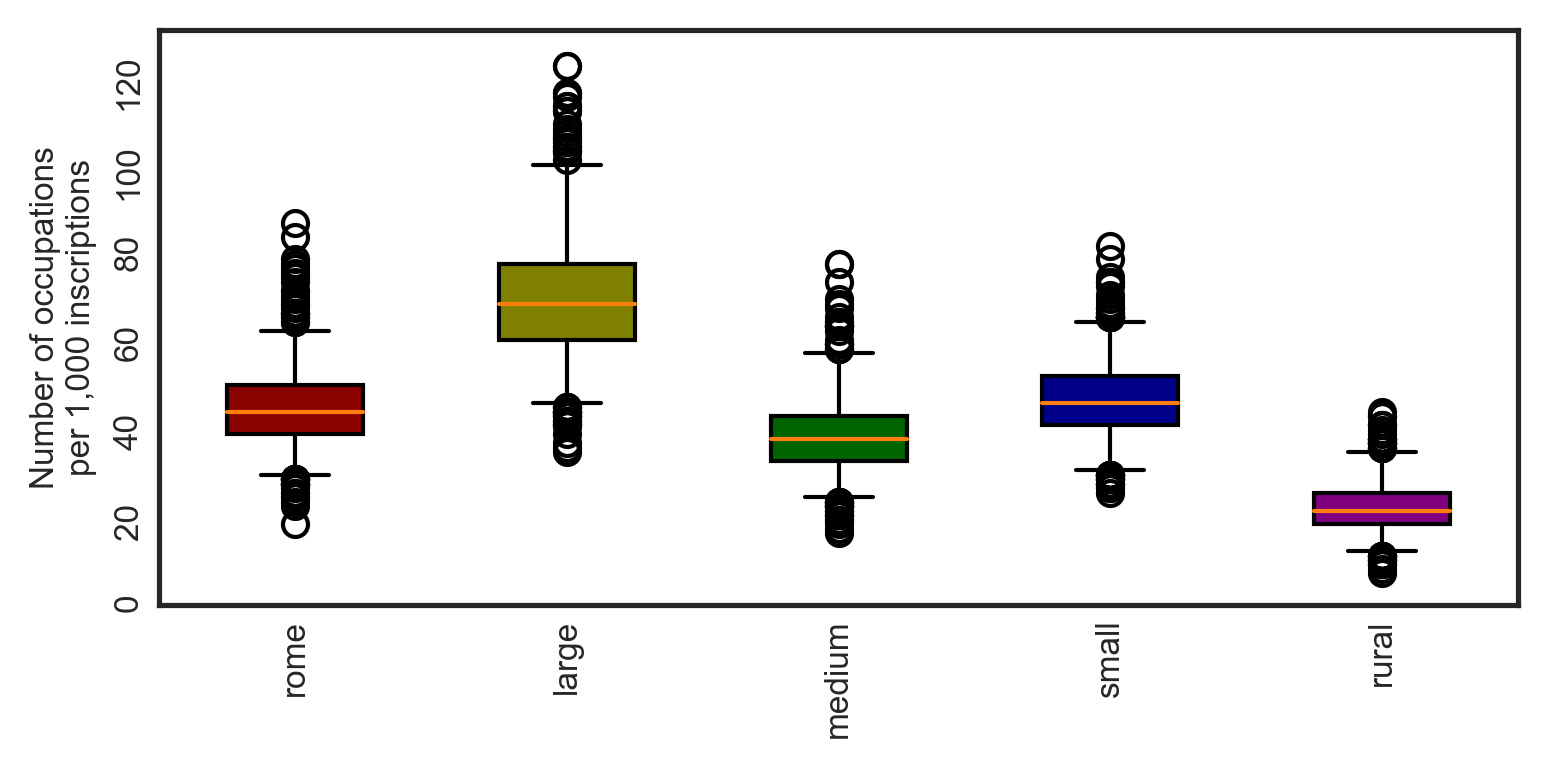

In [62]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

labels = ["rome", "large", "medium", "small", "rural"]

fig, ax1 = plt.subplots(figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot(lire_occups_rome_large + [lire_occups_large_medium[1]] + lire_occups_small_rural, whis=[2.5, 97.5], labels=labels,
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 128)

# fill with colors
colors = ["darkred", "olive","darkgreen", "darkblue", "purple"]
#for bplot in bplot1:
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

In [63]:
save_figure(fig, "occups_by_context_box_rome_separately")

Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_by_context_box_rome_separately.png"


# By industry type

In [65]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")

def term1_plus_term2(row):
    term1_2 = row["Term"]
    if isinstance(row["Term2"], str):
        term1_2 += " " + row["Term2"]
    return term1_2

occupations_df["Term"] = occupations_df.apply(lambda row: term1_plus_term2(row), axis=1)

occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [66]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
LIRE["occups"] = LIRE["occups"].apply(list)
LIRE["occups_cats"] = LIRE["occups"].apply(cat_for_occup)

##  urban contexts

In [67]:
edhcs_occups_cats_data = {}
contexts = ["large", "medium", "small", "rural"]
labels = ["large city", "medium city", "small city", "rural area"]

edhcs_all_present_categories = []
for context, label in zip(
    contexts,
    labels
):
    df_subset = LIRE[LIRE["urban_context_alt"]==context]
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    #wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    #freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    freqs = [(tup[1] / len(df_subset)) * 1000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[label] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Managerial', 'Miscellaneous Services', 'Metal-Working', 'Retail', 'Building', 'Food-Production', 'Clothing', 'Education', 'Unclassified', 'Transport', 'Performing Arts', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Glass-Working'] [10.798383725790721, 8.290372021736102, 4.737355440992058, 4.598021457433468, 3.413682597185453, 3.1117922994751757, 2.600901026427012, 2.508011704054619, 1.6487854721099808, 1.6023408109237844, 0.8360039013515396, 0.7663369095722447, 0.6966699177929497, 0.6270029260136547, 0.5573359342343598, 0.2554456365240816, 0.13933398355858995] 47.1877757651758
['Managerial', 'Unclassified', 'Miscellaneous Services', 'Retail', 'Metal-Working', 'Clothing', 'Performing Arts', 'Building', 'Education', 'Food-Production', 'Transport', 'Finance', 'Plastic Arts', 'Household Goods', 'Food-Retail', 'Water-Management', 'Glass-Working'] [7.840949136614589, 5.491601080700106, 4.728062962527899, 4.669329261130037, 3.08351932338776, 2.2318806531

In [68]:
edhcs_data_by_category = {}
for cat in edhcs_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Miscellaneous Services': [8.290372021736102,
  4.728062962527899,
  4.023677796262622,
  3.2501730416202714],
 'Unclassified': [1.6487854721099808,
  5.491601080700106,
  8.58900452663752,
  2.768665924343194],
 'Transport': [1.6023408109237844, 0, 1.315433125701242, 0.6620722862559812],
 'Education': [2.508011704054619,
  1.6739104898390698,
  2.127906526869656,
  0.7222606759156158],
 'Performing Arts': [0, 1.850111594032656, 2.476109413084691, 0],
 'Retail': [4.598021457433468,
  4.669329261130037,
  2.2052849460285526,
  1.8959342742784915],
 'Building': [3.413682597185453,
  1.7913778926347939,
  2.901690718458622,
  1.6551807156399532],
 'Metal-Working': [4.737355440992058,
  3.08351932338776,
  4.217123844159864,
  3.9122453278762532],
 'Food-Production': [3.1117922994751757,
  1.321508281451897,
  0,
  0.7222606759156158],
 'Managerial': [10.798383725790721,
  7.840949136614589,
  12.071033388787866,
  4.032622107195522],
 'Clothing': [2.600901026427012,
  2.2318806531187594,

In [69]:
sorted_by_large = sorted([(key,edhcs_data_by_category[key]) for key in edhcs_data_by_category], key=lambda tup: tup[1][0], reverse=True)
sorted_by_large_cats =[el[0] for el in sorted_by_large if el[0] != "Unclassified"] + ["Unclassified"]
sorted_by_large_cats

['Managerial',
 'Miscellaneous Services',
 'Metal-Working',
 'Retail',
 'Building',
 'Food-Production',
 'Clothing',
 'Education',
 'Transport',
 'Performing Arts',
 'Unclassified']

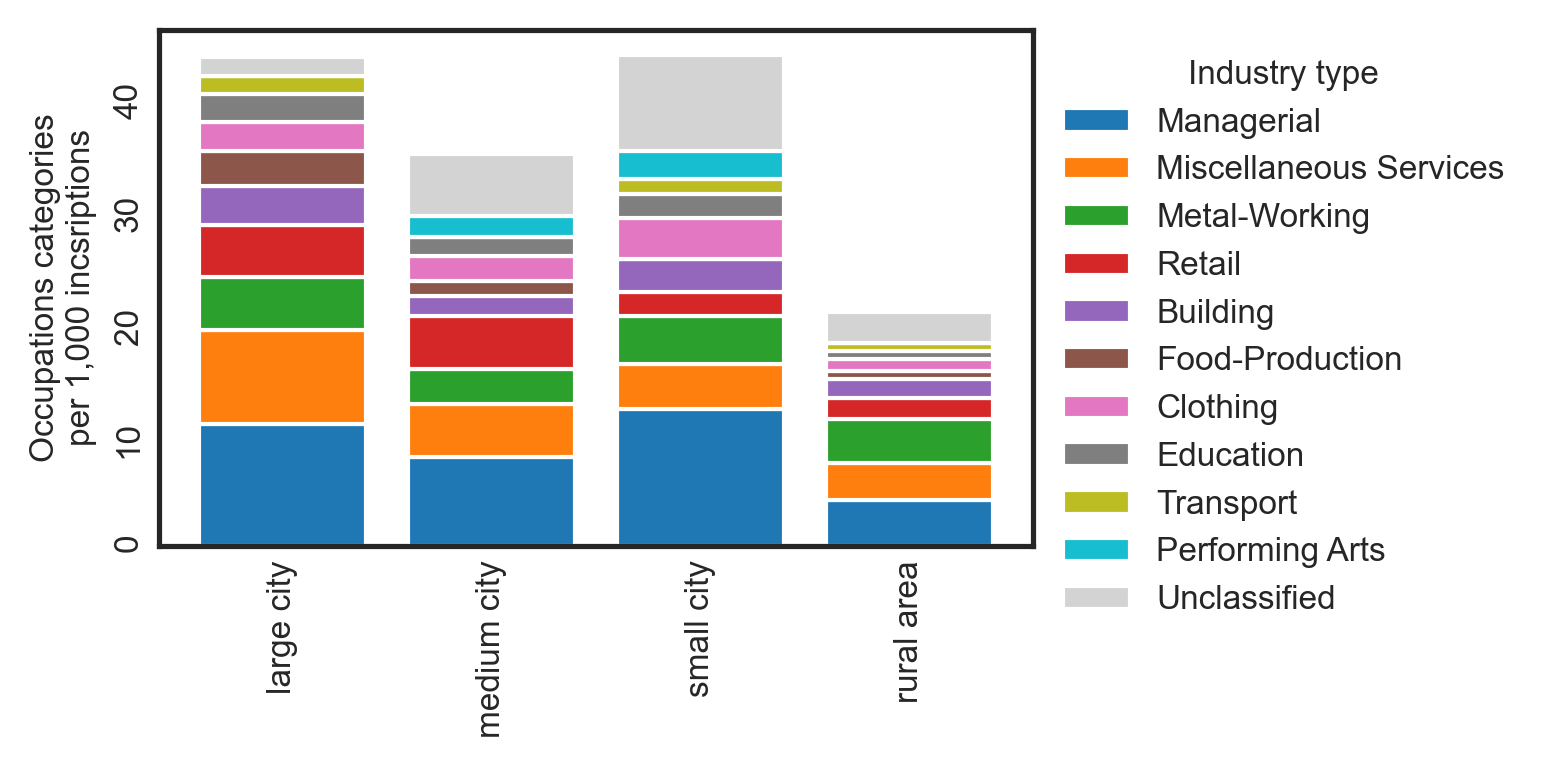

In [70]:
fig, ax = plt.subplots(figsize=[5.2,2.6], tight_layout=True)
#first_bar_cat = sorted_by_large_cats[0]
ax.bar(labels, edhcs_data_by_category[sorted_by_large_cats[0]], label=sorted_by_large_cats[0])
bottom = edhcs_data_by_category[sorted_by_large_cats[0]]

ax.tick_params(labelrotation=90)

for cat in sorted_by_large_cats[1:]:# list(edhcs_data_by_category.keys())[1:]:
    if cat=="Unclassified":
        ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, color="lightgray", label=cat)
    else:
        ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 1,000 incsriptions")

ax.legend(title="Industry type", bbox_to_anchor=(1, 1), fontsize=8)

In [38]:
save_figure(fig, "occups_industrytypes_harris_bar")

A file with the same name ("occups_industrytypes_harris_bar.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_harris_bar.eps"
A file with the same name ("occups_industrytypes_harris_bar.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_harris_bar.png"


# Rome and other large cities treated separately

In [102]:
len(LIRE[(LIRE["urban_context_alt"]=="large") & (LIRE["nearest_city"]!="Roma")])

5297

In [106]:
df_subset = LIRE[LIRE["urban_context_alt"]=="large"]
df_subset[df_subset["nearest_city"]!="Roma"]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry,is_western,large_city_ID,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,"['Augusti/Augustae', 'viri']",{ },,,to 276; b: 276 to 282 \n\n \n \nImp...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,http://db.edcs.eu/epigr/partner.php?s_language...,NaN,276,Augusti/Augustae; miliaria; viri,37.454501,22.420877,None,lapis,None,HD051000,None,Imperatori Floriano Pio Felici Augusto patri p...,Cowey,mile-/leaguestone,3.3-6 cm,"AE 1995, 1409.; M. Iozzer - M. Pangano, ASAA 6...",checked with photo,(44) cm,[ ] / AN[ ] FLORIANO / P F AVG / P P / M P III...,"[{'person_id': '1', 'nomen': 'Annius+', 'name'...",None,None,mile-/leaguestone,Achaia,24 cm,[Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Tegea,2011-05-24,Pelopónissos,Alea,https://edh-www.adw.uni-heidelberg.de/edh/geog...,"Die erste Inschrift ist auf 276, die zweite a...",https://www.trismegistos.org/text/177273,{ },{ },177273,"['http://www.trismegistos.org/place/000078', '...",Imperatori Caesari Marco Annio Floriano Pio Fe...,276 AD,21,unbestimmt,89.0,Meilen-/Leugenstein,138,unbestimmt,1000.0,102,Meilen-/Leugenstein,mile-/leaguestone,Certain,44.0,24.0,NaN,NULL,mile-/leaguestone,Certain,Achaia,Certain,Greece,Certain,Tegea,Certain,Pelopónissos,Certain,Alea,Certain,"Stringu, bei",Certain,276 AD,An Floriano P F Aug p p m p III Imp Caes M Aur...,Imperatori Caesari Marco Annio Floriano Pio Fe...,"Stringu, bei",None,"Tegea, Mus.",None,None,data available,None,NaN,Latin,276.0,"[22.4171, 37.4319]",Imperatori Caesari Marco Annio Floriano Pio Fe...,big,False,Tegea,97,46362.0,"[22.417226, 37.427653]",big,0.004249,mile-/leaguestone,1.00,POINT (22.41710 37.43190),False,97,"[22.417226, 37.427653]",471.49,55,"[22.405305, 37.642803]",23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']

In [112]:
edhcs_occups_cats_data = {}
contexts = ["large", "medium", "small", "rural"]

edhcs_all_present_categories = []
for context in contexts:
    df_subset = LIRE[LIRE["urban_context_alt"]==context]
    if context=="large":
        for subcontext in ["rome", "large"]:
            if subcontext=="rome":
                df_subset = df_subset[df_subset["nearest_city"]=="Roma"]
                print(len(df_subset))
            else:
                df_subset = df_subset[df_subset["nearest_city"]!="Roma"]
                print(len(df_subset))
            occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
            #wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
            occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
            categories = [tup[0] for tup in occups_cats_dist]
            edhcs_all_present_categories.extend(categories[:10])
            #freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
            freqs = [(tup[1] / len(df_subset)) * 1000 for tup in occups_cats_dist]
            cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
            total_freq = np.sum(freqs)
            edhcs_occups_cats_data[subcontext] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
            print(categories, freqs, total_freq)
    else:
        occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
        #wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
        occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
        categories = [tup[0] for tup in occups_cats_dist]
        edhcs_all_present_categories.extend(categories[:10])
        #freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
        freqs = [(tup[1] / len(df_subset)) * 1000 for tup in occups_cats_dist]
        cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
        total_freq = np.sum(freqs)
        edhcs_occups_cats_data[context] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
        print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

37765
['Managerial', 'Miscellaneous Services', 'Retail', 'Metal-Working', 'Food-Production', 'Clothing', 'Building', 'Education', 'Unclassified', 'Performing Arts', 'Plastic Arts', 'Finance', 'Food-Retail', 'Transport', 'Household Goods', 'Water-Management', 'Glass-Working'] [10.64477690983715, 8.182179266516616, 4.316165761948895, 4.28968621739706, 3.2569839798755464, 2.674433999735205, 2.647954455183371, 2.4625976433205348, 1.376936316695353, 0.8473454256586787, 0.7943863365550113, 0.7149477028995102, 0.5560704355885079, 0.5031113464848405, 0.47663180193300675, 0.2912749900701708, 0.15887726731100224] 44.19435985701046
0
[] [] 0.0
['Managerial', 'Unclassified', 'Miscellaneous Services', 'Retail', 'Metal-Working', 'Clothing', 'Performing Arts', 'Building', 'Education', 'Food-Production', 'Transport', 'Finance', 'Plastic Arts', 'Household Goods', 'Food-Retail', 'Water-Management', 'Glass-Working'] [7.840949136614589, 5.491601080700106, 4.728062962527899, 4.669329261130037, 3.0835193233

In [90]:
edhcs_occups_cats_data

{'rome': {'categories': ['Managerial',
   'Miscellaneous Services',
   'Retail',
   'Metal-Working',
   'Food-Production',
   'Clothing',
   'Building',
   'Education',
   'Unclassified',
   'Performing Arts',
   'Plastic Arts',
   'Finance',
   'Food-Retail',
   'Transport',
   'Household Goods',
   'Water-Management',
   'Glass-Working'],
  'freqs': [10.64477690983715,
   8.182179266516616,
   4.316165761948895,
   4.28968621739706,
   3.2569839798755464,
   2.674433999735205,
   2.647954455183371,
   2.4625976433205348,
   1.376936316695353,
   0.8473454256586787,
   0.7943863365550113,
   0.7149477028995102,
   0.5560704355885079,
   0.5031113464848405,
   0.47663180193300675,
   0.2912749900701708,
   0.15887726731100224],
  'cat_freq_dict': {'Managerial': 10.64477690983715,
   'Miscellaneous Services': 8.182179266516616,
   'Retail': 4.316165761948895,
   'Metal-Working': 4.28968621739706,
   'Food-Production': 3.2569839798755464,
   'Clothing': 2.674433999735205,
   'Building': 

In [86]:
edhcs_data_by_category = {}
for cat in edhcs_all_present_categories:
    cat_data = []
    for label in ["rome", "large", "medium", "small", "rural"]:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Miscellaneous Services': [8.182179266516616,
  0,
  4.728062962527899,
  4.023677796262622,
  3.2501730416202714],
 'Unclassified': [1.376936316695353,
  0,
  5.491601080700106,
  8.58900452663752,
  2.768665924343194],
 'Transport': [0, 0, 0, 1.315433125701242, 0.6620722862559812],
 'Education': [2.4625976433205348,
  0,
  1.6739104898390698,
  2.127906526869656,
  0.7222606759156158],
 'Performing Arts': [0.8473454256586787,
  0,
  1.850111594032656,
  2.476109413084691,
  0],
 'Retail': [4.316165761948895,
  0,
  4.669329261130037,
  2.2052849460285526,
  1.8959342742784915],
 'Building': [2.647954455183371,
  0,
  1.7913778926347939,
  2.901690718458622,
  1.6551807156399532],
 'Metal-Working': [4.28968621739706,
  0,
  3.08351932338776,
  4.217123844159864,
  3.9122453278762532],
 'Food-Production': [3.2569839798755464,
  0,
  1.321508281451897,
  0,
  0.7222606759156158],
 'Managerial': [10.64477690983715,
  0,
  7.840949136614589,
  12.071033388787866,
  4.032622107195522],
 '

In [87]:
sorted_by_large = sorted([(key,edhcs_data_by_category[key]) for key in edhcs_data_by_category], key=lambda tup: tup[1][0], reverse=True)
sorted_by_large_cats =[el[0] for el in sorted_by_large if el[0] != "Unclassified"] + ["Unclassified"]
sorted_by_large_cats

['Managerial',
 'Miscellaneous Services',
 'Retail',
 'Metal-Working',
 'Food-Production',
 'Clothing',
 'Building',
 'Education',
 'Performing Arts',
 'Transport',
 'Unclassified']

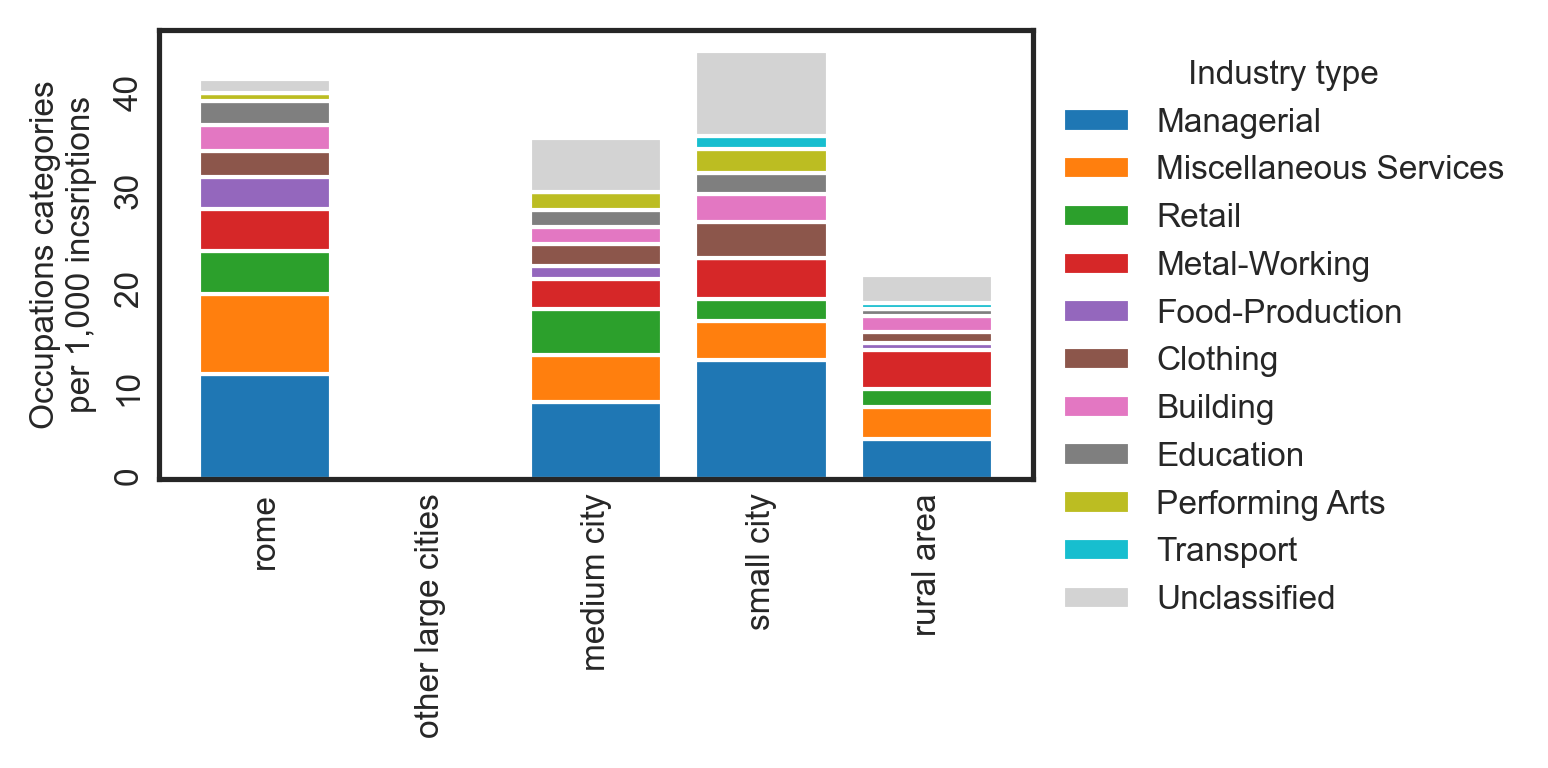

In [88]:
fig, ax = plt.subplots(figsize=[5.2,2.6], tight_layout=True)
#first_bar_cat = sorted_by_large_cats[0]
ax.bar(labels, edhcs_data_by_category[sorted_by_large_cats[0]], label=sorted_by_large_cats[0])
bottom = edhcs_data_by_category[sorted_by_large_cats[0]]

ax.tick_params(labelrotation=90)

for cat in sorted_by_large_cats[1:]:# list(edhcs_data_by_category.keys())[1:]:
    if cat=="Unclassified":
        ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, color="lightgray", label=cat)
    else:
        ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 1,000 incsriptions")

ax.legend(title="Industry type", bbox_to_anchor=(1, 1), fontsize=8)

## Hisco categories

In [41]:
occupations_df["Term"] = occupations_df["Term"].apply(lambda x: x.replace(" ", "_"))

In [42]:
hisco_cats_dict = {
    0.0 : "Professional, technical and related workers",
    1.0 : "Professional, technical and related workers",
    2.0 : "Administrative and managerial workers",
    3.0 : "Clerical and related workers",
    4.0 : "Sales workers",
    5.0 : "Service workers",
    6.0 : "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    7.0 : "Production and related workers, transport equipment operators and labourers",
    8.0 : "Production and related workers, transport equipment operators and labourers",
    9.0 : "Production and related workers, transport equipment operators and labourers",
}

In [43]:
hisco_cats_labels = list(set(hisco_cats_dict.values())) + ["Unclassified"]
hisco_cats_labels

['Clerical and related workers',
 'Production and related workers, transport equipment operators and labourers',
 'Service workers',
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters',
 'Sales workers',
 'Professional, technical and related workers',
 'Administrative and managerial workers',
 'Unclassified']

In [44]:
def hisco_literary(hisco_code):
    try:
        return hisco_cats_dict[float(hisco_code)]
    except:
        return "unclassified"
occupations_df["hisco_cats"] = occupations_df["HISCO_majorgroup"].apply(hisco_literary)

In [45]:
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["hisco_cats"]))
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
LIRE["occups_cats"] = LIRE["occups"].apply(cat_for_occup)

In [46]:
edhcs_occups_cats_data = {}

contexts = ["large", "medium", "small", "rural"]
labels = ["large city", "medium city", "small city", "rural area"]

edhcs_all_present_categories = []
for context, label in zip(
    contexts,
    labels
):
    df_subset = LIRE[LIRE["urban_context_alt"]==context]
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    #wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / len(df_subset)) * 1000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[label] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Production and related workers, transport equipment operators and labourers', 'Administrative and managerial workers', 'Professional, technical and related workers', 'Service workers', 'Sales workers', 'Clerical and related workers', 'Agricultural, animal husbandry and forestry workers, fishermen and hunters', 'unclassified'] [13.422507082810831, 10.148158469183967, 6.571919557846826, 4.783800102178255, 4.760577771585156, 3.018902977102782, 1.2772281826204077, 0.06966699177929497] 44.05276113510752
['Production and related workers, transport equipment operators and labourers', 'Administrative and managerial workers', 'Professional, technical and related workers', 'Sales workers', 'Clerical and related workers', 'Service workers', 'Agricultural, animal husbandry and forestry workers, fishermen and hunters', 'unclassified'] [13.949254081992247, 7.547280629625279, 5.550334782097968, 4.287560202043933, 2.466815458710208, 1.7326441912369317, 0.7048044167743451, 0.02936685069893105] 36.268

In [47]:
edhcs_occups_cats_data

{'large city': {'categories': ['Production and related workers, transport equipment operators and labourers',
   'Administrative and managerial workers',
   'Professional, technical and related workers',
   'Service workers',
   'Sales workers',
   'Clerical and related workers',
   'Agricultural, animal husbandry and forestry workers, fishermen and hunters',
   'unclassified'],
  'freqs': [13.422507082810831,
   10.148158469183967,
   6.571919557846826,
   4.783800102178255,
   4.760577771585156,
   3.018902977102782,
   1.2772281826204077,
   0.06966699177929497],
  'cat_freq_dict': {'Production and related workers, transport equipment operators and labourers': 13.422507082810831,
   'Administrative and managerial workers': 10.148158469183967,
   'Professional, technical and related workers': 6.571919557846826,
   'Service workers': 4.783800102178255,
   'Sales workers': 4.760577771585156,
   'Clerical and related workers': 3.018902977102782,
   'Agricultural, animal husbandry and fo

In [48]:
hisco_cats_labels = [
    "Professional, technical and related workers",
    "Administrative and managerial workers",
    "Clerical and related workers",
    "Sales workers",
    "Service workers",
    "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    "Production and related workers, transport equipment operators and labourers",
    "Unclassified"
]

In [49]:
edhcs_data_by_category = {}
for cat in hisco_cats_labels:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Professional, technical and related workers': [6.571919557846826,
  5.550334782097968,
  5.842070646496691,
  2.5279123657046556],
 'Administrative and managerial workers': [10.148158469183967,
  7.547280629625279,
  11.606762873834487,
  3.9724337175358877],
 'Clerical and related workers': [3.018902977102782,
  2.466815458710208,
  2.7856230897202767,
  1.0532968190436063],
 'Sales workers': [4.760577771585156,
  4.287560202043933,
  2.127906526869656,
  1.745463300129405],
 'Service workers': [4.783800102178255,
  1.7326441912369317,
  1.2380547065423455,
  0.5717897017665293],
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters': [1.2772281826204077,
  0.7048044167743451,
  0.657716562850621,
  0.4213187276174426],
 'Production and related workers, transport equipment operators and labourers': [13.422507082810831,
  13.949254081992247,
  19.615429256780285,
  10.92419272322369],
 'Unclassified': [0, 0, 0, 0]}

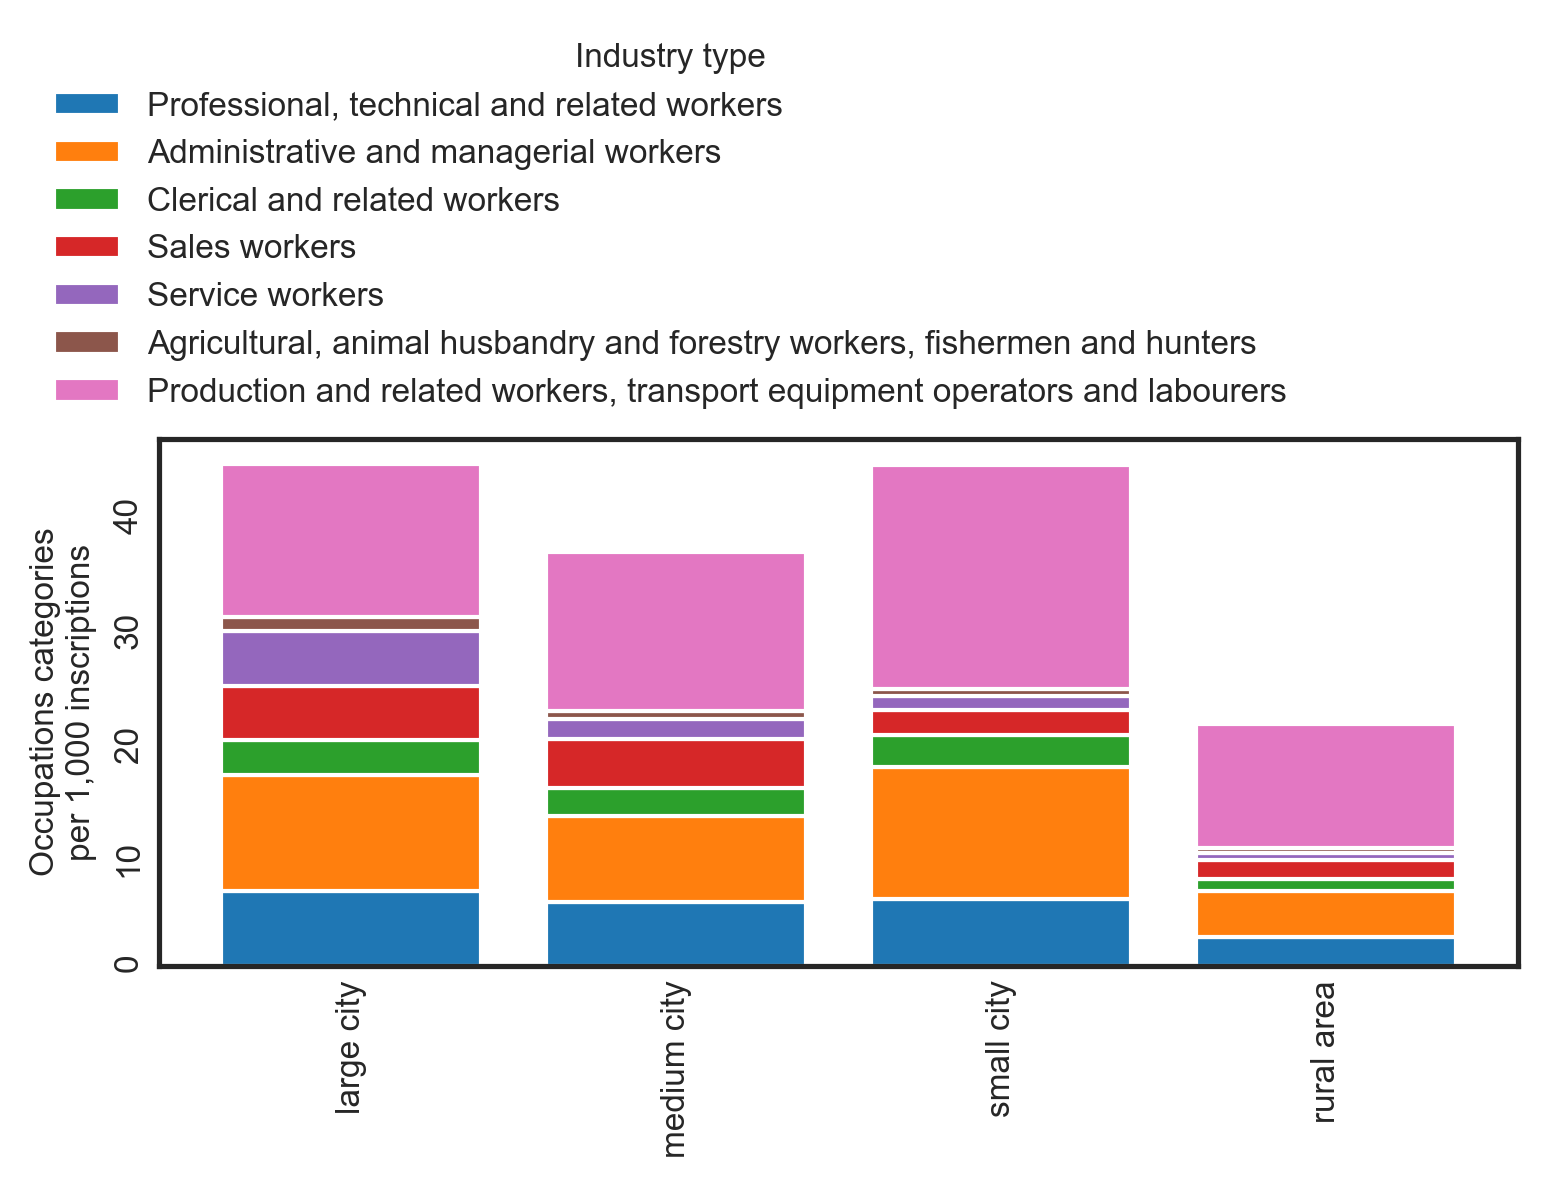

In [50]:
fig, ax = plt.subplots(figsize=[5.2,4], tight_layout=True)
first_bar_cat = hisco_cats_labels[0]

ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in hisco_cats_labels[1:-1]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 1,000 inscriptions")
ax.legend(title="Industry type", bbox_to_anchor=(-0.1, 1), loc="lower left", fontsize=8)

In [51]:
save_figure(fig, "occups_industrytypes_hisco_bar")

A file with the same name ("occups_industrytypes_hisco_bar.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_hisco_bar.eps"
A file with the same name ("occups_industrytypes_hisco_bar.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_hisco_bar.png"


In [52]:
LIRE.to_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")